In [1]:
import sys
sys.path.append('../app')

import os, pickle
import numpy as np
import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.optim.lr_scheduler import ReduceLROnPlateau

import torchvision.models as models

from sklearn.metrics import classification_report, confusion_matrix

import seaborn as sns
import matplotlib.pyplot as plt

from config import Config
from process_images import ImageUtils

%matplotlib inline
%config IPCompleter.greedy=True
%config Completer.use_jedi = False

In [2]:
conf = Config()
conf.im_size = 128

im_utils = ImageUtils(conf)

## Train GoogLeNet on 3 class combined dataset

In [39]:
x = torch.load('%s/x_%d.pt' % (conf.combined_data_path, conf.im_size))
y = torch.load('%s/y.pt' % (conf.combined_data_path)).type(torch.LongTensor)
with open('%s/im_names.txt' % (conf.combined_data_path), 'r') as f:
    im_names = f.read().split('\n')

x.shape

torch.Size([2973, 3, 128, 128])

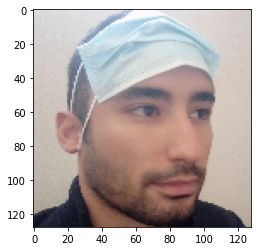

In [17]:
im_utils.show_image(x[2])

In [8]:
# load 3 class label to index map
with open('%s/lab2idx.pkl' % conf.combined_data_path, 'rb') as f:
    lab2idx = pickle.load(f)
lab2idx

{'without_mask': 0, 'with_mask': 1, 'mask_weared_incorrect': 2}

In [40]:
# divide data into train/crossval/test

x_test = x[:500]
y_test = y[:500]
test_im_names = im_names[:500]

x_cv = x[500:750]
y_cv = y[500:750]
cv_im_names = im_names[500:750]

x_train = x[750:]
y_train = y[750:]
train_im_names = im_names[750:]

x_train.shape, x_cv.shape, x_test.shape

(torch.Size([2223, 3, 128, 128]),
 torch.Size([250, 3, 128, 128]),
 torch.Size([500, 3, 128, 128]))

In [19]:
def finetune_model(model, optimizer, model_path, lab2idx, 
                   x_train, y_train, x_cv, y_cv, x_test, y_test,
                   device, batch_size=32, n_epochs=20):
    model.train()
    criterion = nn.CrossEntropyLoss()
    scheduler = ReduceLROnPlateau(optimizer, 'min', patience=10)
    train_losses = []
    cv_losses = []
    
    if not os.path.exists(model_path):
        os.mkdir(model_path)

    best_acc = 0
    
    for epoch in range(n_epochs):
        print('Epoch: %d' % epoch)
        
        idx = torch.randperm(x_train.size(0))
        x_train = x_train[idx]
        y_train = y_train[idx]
        
        ep_ttl = 0
   
        for j in range(0, x_train.size(0), batch_size):
            ep_ttl += 1
            x_batch = x_train[j:j+batch_size].to(device)
            y_batch = y_train[j:j+batch_size].to(device)

            #reset gradient for this iteration
            optimizer.zero_grad()

            #run the data through the model
            output = model(x_batch)

            #get the negative log likelihood loss
            loss = criterion(output, y_batch)

            #calculate the gradients
            loss.backward()

            #update the parameters from the gradients
            optimizer.step()

            if ep_ttl%50==0:
                print('Epoch: %d, Batch: %d, Loss: %.6f' % (epoch, j, loss.item()))
                train_losses.append(loss.item())

        ##### more testing, used to be at epoch level
        print('Testing model...')
        acc, cv_loss = test(model, criterion, x_cv, y_cv, lab2idx)
        scheduler.step(cv_loss)
        cv_losses.append(cv_loss)
        print('CV accuracy %.6f, prev best acc: %.6f %s\n' % (acc, best_acc, '!! IMPROVED !!' if acc>best_acc else ''))

        if acc>best_acc:
            best_acc = acc
            no_improvement = 0
            print('Saving model...')
            torch.save(model.state_dict(), '%s/model.pt' % model_path)
            torch.save(optimizer.state_dict(), '%s/optimizer.pt' % model_path)
        else:
            no_improvement += 1

        if no_improvement >= 50:
            print('no improvement in several epochs, breaking')
            break
            
    model.load_state_dict(torch.load('%s/model.pt' % model_path))
    test_acc, _ = test(model, criterion, x_test, y_test, lab2idx, True)
    print('final test accuracy: %.6f' % test_acc)
    model.eval()
    
    return model, train_losses, cv_losses

            
def test(model, criterion, x_test, y_test, lab2idx, print_report=False):
    model.eval()
    
    correct = 0
    loss = 0
    with torch.no_grad():
        output = model(x_test)
        
        loss = criterion(output, y_test)
        
        #select the indices of the maximum output values/prediction
        _, y_pred = torch.max(output, 1)

        #compare them with the target digits and sum correct predictions
        correct = y_pred.eq(y_test).sum()
        
    acc = correct / y_test.size()[0]
    
    print('Test accuracy %.6f, %d of %d' % (acc, correct, y_test.size(0)))
    
    if print_report:
        idx2lab = {v:k for k,v in lab2idx.items()}
        class_labels = [idx2lab[i] for i in range(len(idx2lab))]
        
        print('\n\n')
        print(classification_report(y_test.tolist(), y_pred.tolist(), target_names=class_labels, digits=4))
        print('\n\n')
    
        cm = confusion_matrix(y_test.tolist(), y_pred.tolist())
        fig, ax = plt.subplots(figsize=(12,10))
        f = sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_labels, yticklabels=class_labels, ax=ax)
    
    model.train()
    
    return acc, loss.item()

In [10]:
model = models.googlenet(pretrained=True)
model

GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

In [11]:
model.fc = nn.Linear(1024, len(lab2idx))

In [12]:
optimizer = optim.AdamW(model.parameters(), lr=1e-4)

Epoch: 0
Epoch: 0, Batch: 392, Loss: 0.442851
Epoch: 0, Batch: 792, Loss: 0.705809
Epoch: 0, Batch: 1192, Loss: 0.403428
Epoch: 0, Batch: 1592, Loss: 1.555436
Epoch: 0, Batch: 1992, Loss: 0.350390
Testing model...
Test accuracy 0.924000, 231 of 250
CV accuracy 0.924000, prev best acc: 0.000000 !! IMPROVED !!
Saving model...
Epoch: 1
Epoch: 1, Batch: 392, Loss: 0.170749
Epoch: 1, Batch: 792, Loss: 0.376148
Epoch: 1, Batch: 1192, Loss: 0.066875
Epoch: 1, Batch: 1592, Loss: 0.511688
Epoch: 1, Batch: 1992, Loss: 0.188354
Testing model...
Test accuracy 0.944000, 236 of 250
CV accuracy 0.944000, prev best acc: 0.924000 !! IMPROVED !!
Saving model...
Epoch: 2
Epoch: 2, Batch: 392, Loss: 1.756253
Epoch: 2, Batch: 792, Loss: 0.075338
Epoch: 2, Batch: 1192, Loss: 0.312643
Epoch: 2, Batch: 1592, Loss: 0.014179
Epoch: 2, Batch: 1992, Loss: 0.019474
Testing model...
Test accuracy 0.924000, 231 of 250
CV accuracy 0.924000, prev best acc: 0.944000 
Epoch: 3
Epoch: 3, Batch: 392, Loss: 0.245336
Epoch:

Epoch: 27, Batch: 392, Loss: 0.001420
Epoch: 27, Batch: 792, Loss: 0.000417
Epoch: 27, Batch: 1192, Loss: 0.000324
Epoch: 27, Batch: 1592, Loss: 0.001162
Epoch: 27, Batch: 1992, Loss: 0.000918
Testing model...
Test accuracy 0.968000, 242 of 250
CV accuracy 0.968000, prev best acc: 0.976000 
Epoch: 28
Epoch: 28, Batch: 392, Loss: 0.001898
Epoch: 28, Batch: 792, Loss: 0.000139
Epoch: 28, Batch: 1192, Loss: 0.004928
Epoch: 28, Batch: 1592, Loss: 0.000850
Epoch: 28, Batch: 1992, Loss: 0.000729
Testing model...
Test accuracy 0.960000, 240 of 250
CV accuracy 0.960000, prev best acc: 0.976000 
Epoch: 29
Epoch: 29, Batch: 392, Loss: 0.000673
Epoch: 29, Batch: 792, Loss: 0.000346
Epoch: 29, Batch: 1192, Loss: 0.007288
Epoch: 29, Batch: 1592, Loss: 0.000248
Epoch: 29, Batch: 1992, Loss: 0.000655
Testing model...
Test accuracy 0.964000, 241 of 250
CV accuracy 0.964000, prev best acc: 0.976000 
Epoch: 30
Epoch: 30, Batch: 392, Loss: 0.000175
Epoch: 30, Batch: 792, Loss: 0.000553
Epoch: 30, Batch: 

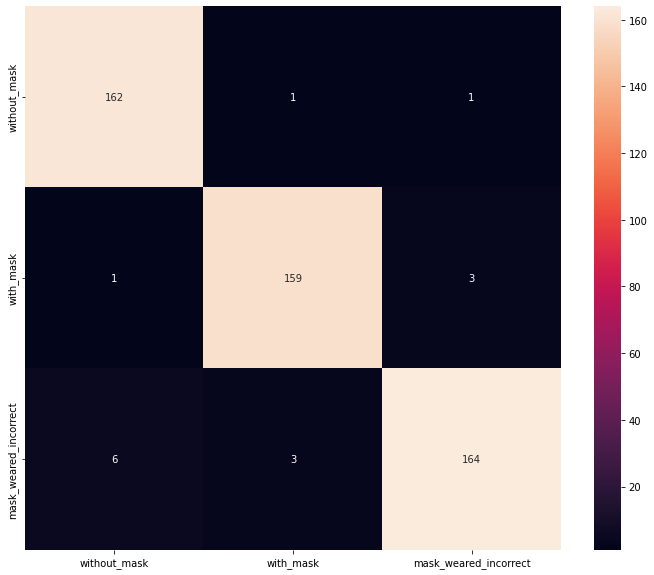

In [20]:
# train model and store when crossval score increases

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

model_path = 'googlenet_3class_model'
if not os.path.exists(model_path):
    os.mkdir(model_path)
    
model, train_losses, cv_losses = finetune_model(model, optimizer, model_path, lab2idx,
                                                x_train, y_train, x_cv, y_cv, x_test, y_test,
                                                device, batch_size=8, n_epochs=30)

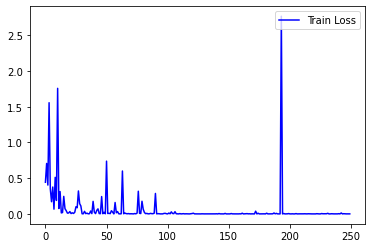

In [21]:
fig = plt.figure()
plt.plot(train_losses, color='blue')
plt.legend(['Train Loss'], loc='upper right')

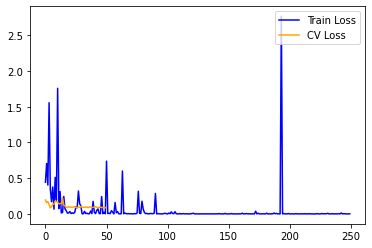

In [26]:
fig = plt.figure()
plt.plot(train_losses, color='blue')
plt.plot(cv_losses, color='orange')
plt.legend(['Train Loss', 'CV Loss'], loc='upper right')
plt.show()

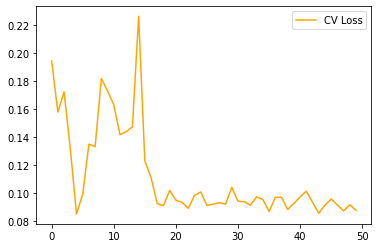

In [22]:
fig = plt.figure()
plt.plot(cv_losses, color='orange')
plt.legend(['CV Loss'], loc='upper right')
plt.show()

### Visualize incorrect predictions

In [23]:
model.eval()
with torch.no_grad():
    output = model(x_test)
    
    #select the indices of the maximum output values/prediction
    _, y_pred = torch.max(output, 1)

    #compare them with the target digits and sum correct predictions
    correct = y_pred.eq(y_test)

wrong_idx = (correct==False).nonzero(as_tuple=True)[0]
wrong_idx

c:\ml\env\lib\site-packages\torch\nn\functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"


tensor([  0,  30, 110, 113, 155, 162, 290, 317, 320, 341, 351, 414, 420, 441,
        494])



maksssksksss264.png - predicted: without_mask, ground truth: with_mask


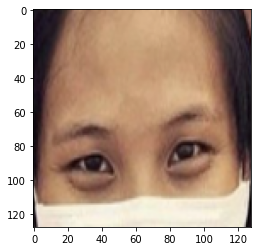



0042_MRTN_DRNV_0045 - predicted: without_mask, ground truth: mask_weared_incorrect


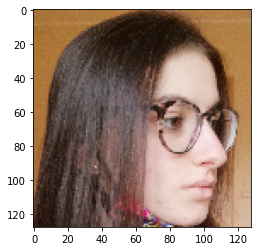



0004_MRNC_SRGM_0000 - predicted: with_mask, ground truth: mask_weared_incorrect


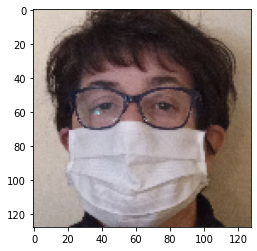



maksssksksss791.png - predicted: mask_weared_incorrect, ground truth: with_mask


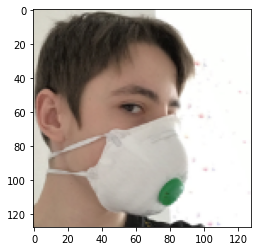



seed0782.png - predicted: mask_weared_incorrect, ground truth: without_mask


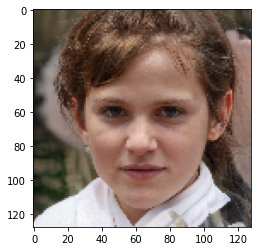



0006_MRNN_SRGM_0000 - predicted: without_mask, ground truth: mask_weared_incorrect


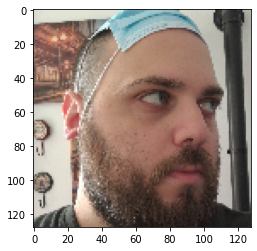



0015_MRNC_DRNV_0000 - predicted: mask_weared_incorrect, ground truth: with_mask


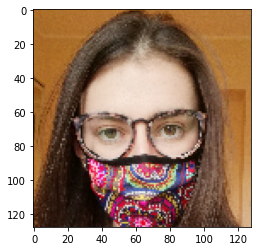



maksssksksss743.png - predicted: mask_weared_incorrect, ground truth: with_mask


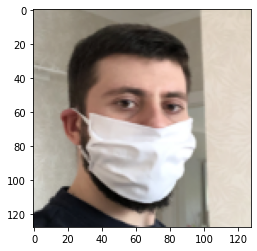



maksssksksss347.png - predicted: with_mask, ground truth: without_mask


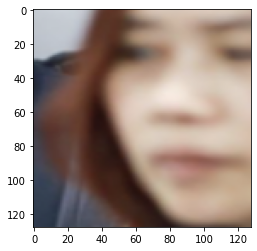



0015_MRNW_0000 - predicted: without_mask, ground truth: mask_weared_incorrect


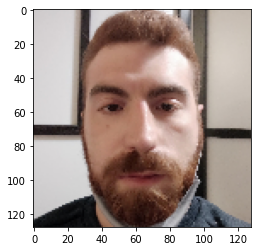



0002_MRFH_SRGM_0000 - predicted: without_mask, ground truth: mask_weared_incorrect


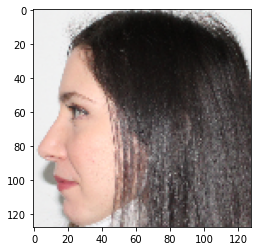



0016_MRNC_NMDM_0045 - predicted: without_mask, ground truth: mask_weared_incorrect


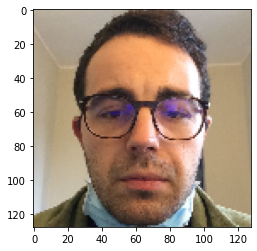



maksssksksss748.png - predicted: without_mask, ground truth: mask_weared_incorrect


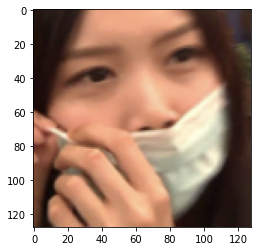



0003_MRFH_SRGM_0045 - predicted: with_mask, ground truth: mask_weared_incorrect


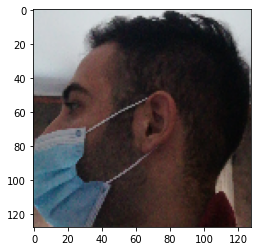



0004_MSFC_NMDM_0000 - predicted: with_mask, ground truth: mask_weared_incorrect


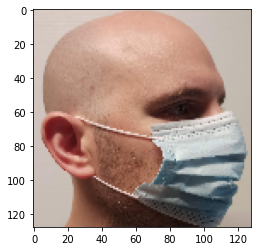

In [25]:
idx2lab = {v:k for k,v in lab2idx.items()}

for idx in wrong_idx.tolist():
    im = x_test[idx]
    corr = y_test[idx].item()
    pred = y_pred[idx].item()
    nm = test_im_names[idx]
    print('\n\n%s - predicted: %s, ground truth: %s' % (nm, idx2lab[pred], idx2lab[corr]))
    im_utils.show_image(im)

## Train Inceptionv3

In [47]:
def resize_image_tensors(xs, new_size):
    xs_resized = []

    for i in range(xs.shape[0]):
        x_im = xs[i]
        x_im = torch.swapaxes(x_im, 0, 2)
        x_resized = cv2.resize(x_im.numpy(), (new_size, new_size), interpolation = cv2.INTER_LINEAR)
        x_resized = torch.swapaxes(torch.from_numpy(x_resized), 0, 2)
        xs_resized.append(x_resized)

    return torch.stack(xs_resized)

In [50]:
x_train_resized = resize_image_tensors(x_train, new_size=299)
x_cv_resized = resize_image_tensors(x_cv, new_size=299)
x_test_resized = resize_image_tensors(x_test, new_size=299)

x_train_resized.shape, x_cv_resized.shape, x_test_resized.shape

(torch.Size([2223, 3, 299, 299]),
 torch.Size([250, 3, 299, 299]),
 torch.Size([500, 3, 299, 299]))

In [54]:
torch.save(x_train_resized, '%s/x_train_299.pt' % (conf.combined_data_path))
torch.save(x_cv_resized, '%s/x_cv_299.pt' % (conf.combined_data_path))
torch.save(x_test_resized, '%s/x_test_299.pt' % (conf.combined_data_path))

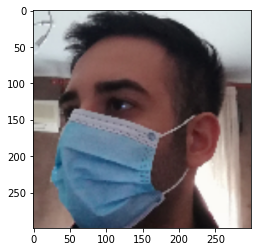

In [51]:
im_utils.show_image(x_train_resized[0])

In [52]:
model_incep = models.inception_v3(pretrained=True, aux_logits=False)
model_incep.fc = nn.Linear(2048, 3)

In [53]:
optimizer = optim.AdamW(model_incep.parameters(), lr=1e-4)

In [ ]:
# train model and store when crossval score increases

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

model_path = 'inceptionv3_3class_model'
if not os.path.exists(model_path):
    os.mkdir(model_path)
    
model_incep, train_losses, cv_losses = finetune_model(model_incep, optimizer, model_path, lab2idx,
                                                x_train_resized, y_train, x_cv_resized, y_cv, x_test_resized, y_test,
                                                device, batch_size=8, n_epochs=30)

In [ ]:
fig = plt.figure()
plt.plot(train_losses, color='blue')
plt.legend(['Train Loss'], loc='upper right')

In [ ]:
fig = plt.figure()
plt.plot(cv_losses, color='orange')
plt.legend(['CV Loss'], loc='upper right')
plt.show()

In [ ]:
model_incep.eval()
with torch.no_grad():
    output = model_incep(x_test_resized)
    _, y_pred = torch.max(output, 1)
    correct = y_pred.eq(y_test)

wrong_idx = (correct==False).nonzero(as_tuple=True)[0]
wrong_idx

In [ ]:
idx2lab = {v:k for k,v in lab2idx.items()}

for idx in wrong_idx.tolist():
    im = x_test[idx]
    corr = y_test[idx].item()
    pred = y_pred[idx].item()
    nm = test_im_names[idx]
    print('\n\n%s - predicted: %s, ground truth: %s' % (nm, idx2lab[pred], idx2lab[corr]))
    im_utils.show_image(im)

In [ ]:
# apply differential learning rates

optimizer = optim.AdamW([
    {'params': model.fc.parameters(), 'lr': 1e-3},
    {'params': model.Mixed_7c.parameters(), 'lr': 1e-4},
    {'params': model.Mixed_7b.parameters(), 'lr': 1e-4},
    {'params': model.Mixed_7a.parameters(), 'lr': 1e-5},
    {'params': model.Mixed_6e.parameters(), 'lr': 1e-5},
    {'params': model.Mixed_6d.parameters(), 'lr': 1e-5},
    {'params': model.Mixed_6c.parameters(), 'lr': 1e-6},
    {'params': model.Mixed_6b.parameters(), 'lr': 1e-6},
    {'params': model.Mixed_6a.parameters(), 'lr': 1e-6},
    {'params': model.Mixed_5d.parameters(), 'lr': 1e-7},
    {'params': model.Mixed_5c.parameters(), 'lr': 1e-7},
    {'params': model.Mixed_5b.parameters(), 'lr': 1e-7}
], lr=1e-8)